In [18]:
import mido
from mido import MidiFile, MidiTrack, Message

def split_midi_by_measures(midi_path):
    midi_file = MidiFile(midi_path)
    ticks_per_beat = midi_file.ticks_per_beat

    # Assuming a default of 4/4 time signature and 120 BPM for initialization
    beats_per_measure = 4
    tempo = 500000  # Microseconds per beat (default MIDI tempo)

    for i, track in enumerate(midi_file.tracks):
        current_tick = 0
        measure_start_tick = 0
        measure_number = 0

        new_track = MidiTrack()
        new_midi = MidiFile(ticks_per_beat=ticks_per_beat)
        new_midi.tracks.append(new_track)

        for msg in track:
            current_tick += msg.time

            if msg.type == 'time_signature':
                beats_per_measure = msg.numerator
                # Note: You can also handle the denominator if needed

            if msg.type == 'set_tempo':
                tempo = msg.tempo

            measure_length_ticks = (ticks_per_beat * beats_per_measure * 60 * 1000000) / tempo

            if current_tick - measure_start_tick >= measure_length_ticks:
                # Save the current new_midi to a file or process it
                new_midi.save(f"measure_{measure_number}.mid")
                measure_number += 1
                measure_start_tick = current_tick

                # Reset for the next measure
                new_track = MidiTrack()
                new_midi = MidiFile(ticks_per_beat=ticks_per_beat)
                new_midi.tracks.append(new_track)

            new_track.append(msg)

        # Save the last measure if it has any events
        if len(new_track) > 0:
            new_midi.save(f"measure_{measure_number}.mid")

def midi_note_to_name(note_number):
    # Define a list of note names in one octave
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    
    # Calculate the note name and octave number from the note number
    name = note_names[note_number % 12]
    octave = note_number // 12 - 1  # MIDI note 0 is C-1
    
    return f"{name}{octave}"

In [11]:
midi_path = "cant2.mid"

midi_file = MidiFile(midi_path)

In [20]:
# midi_file.print_tracks(meta_only=True)

for i, track in enumerate(midi_file.tracks):
    print(f"Track {i}: {track.name}")

    # print the first 50 messages in the track
    for msg in track[:50]:
        # for note_on messages print the note and time
        if msg.type == 'note_on':
            print(f"Note: {midi_note_to_name(msg.note)}, Time: {msg.time}")
        else:
            print(msg)
        # print(msg)

Track 0: 
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('key_signature', key='E', time=0)
MetaMessage('set_tempo', tempo=500000, time=0)
control_change channel=0 control=121 value=0 time=0
program_change channel=0 program=0 time=0
control_change channel=0 control=7 value=100 time=0
control_change channel=0 control=10 value=64 time=0
control_change channel=0 control=91 value=0 time=0
control_change channel=0 control=93 value=0 time=0
MetaMessage('midi_port', port=0, time=0)
Note: C#4, Time: 0
Note: F#4, Time: 0
Note: A#4, Time: 0
Note: C#4, Time: 1823
Note: F#4, Time: 0
Note: A#4, Time: 0
Note: C#4, Time: 97
Note: F#4, Time: 0
Note: A4, Time: 0
Note: C#4, Time: 1823
Note: F#4, Time: 0
Note: A4, Time: 0
Note: B3, Time: 97
Note: F#4, Time: 0
Note: B3, Time: 227
Note: F#4, Time: 0
Note: E4, Time: 13
Note: E4, Time: 455
Note: D#4, Time: 25
Note: D#4, Time: 455
Note: E4, Time: 25
Note: E4, Time: 227
Note: F#4

In [113]:
from music21 import converter, note, chord
from typing import List

def split_musicxml_into_bars(score) -> List[List[str]]:
    measures_per_part = []
     
    for part in score.parts:
        # Initialize a list to hold lists of notes for each measure
        measures_notes = []
        # Iterate through each measure in the score
        for measure in part.getElementsByClass('Measure'):
            # Initialize a list to hold note names for the current measure
            measure_notes = []

            # # Iterate through each note in the measure
            # for note in measure.notes:
            #     # Add the note's name (with octave) to the measure's notes list
            #     # Note: This simplification treats chords as single entities and ignores rests.
            #     # You might need to adjust this depending on your specific requirements.
            #     measure_notes.append(note.nameWithOctave)

            # Iterate through each element in the measure
            for elem in measure:
                if isinstance(elem, note.Note):
                    # Add the note's name (with octave) if it's a Note object
                    measure_notes.append([elem.nameWithOctave])
                elif isinstance(elem, chord.Chord):
                    # For Chord objects, add a list of note names (with octave)
                    # This treats chords as a list of notes for simplicity
                    chord_notes = [n.nameWithOctave for n in elem.notes]
                    measure_notes.append(chord_notes)
                # Rests and other elements are ignored in this simplification 

            # Add the current measure's notes list to the measures_notes list
            measures_notes.append(measure_notes)
            # print(measure)
        measures_per_part.append(measures_notes)
    
    return measures_per_part

# Example usage
# musicxml_path = "entretainer.mxl"
musicxml_path = "turca.mxl"
# musicxml_path = "moonlight.mxl"
score = converter.parse(musicxml_path)
unrolled_score = score.expandRepeats()

# parts_notes = split_musicxml_into_bars(score)
parts_notes = split_musicxml_into_bars(unrolled_score)
for i, part in enumerate(parts_notes):
    print(f"Part {i + 1}:")
    for j, measure in enumerate(part):
        print(f"Measure {j + 1}: {measure}")

Part 1:
Measure 1: [['B4'], ['A4'], ['G#4'], ['A4']]
Measure 2: [['C5'], ['D5'], ['C5'], ['B4'], ['C5']]
Measure 3: [['E5'], ['F5'], ['E5'], ['D#5'], ['E5']]
Measure 4: [['B5'], ['A5'], ['G#5'], ['A5'], ['B5'], ['A5'], ['G#5'], ['A5']]
Measure 5: [['C6'], ['A5'], ['C6']]
Measure 6: [['G5'], ['A5'], ['B5'], ['F#5', 'A5'], ['E5', 'G5'], ['F#5', 'A5']]
Measure 7: [['G5'], ['A5'], ['B5'], ['F#5', 'A5'], ['E5', 'G5'], ['F#5', 'A5']]
Measure 8: [['G5'], ['A5'], ['B5'], ['F#5', 'A5'], ['E5', 'G5'], ['D#5', 'F#5']]
Measure 9: [['E5']]
Measure 10: [['B4'], ['A4'], ['G#4'], ['A4']]
Measure 11: [['C5'], ['D5'], ['C5'], ['B4'], ['C5']]
Measure 12: [['E5'], ['F5'], ['E5'], ['D#5'], ['E5']]
Measure 13: [['B5'], ['A5'], ['G#5'], ['A5'], ['B5'], ['A5'], ['G#5'], ['A5']]
Measure 14: [['C6'], ['A5'], ['C6']]
Measure 15: [['G5'], ['A5'], ['B5'], ['F#5', 'A5'], ['E5', 'G5'], ['F#5', 'A5']]
Measure 16: [['G5'], ['A5'], ['B5'], ['F#5', 'A5'], ['E5', 'G5'], ['F#5', 'A5']]
Measure 17: [['G5'], ['A5'], ['B5'],

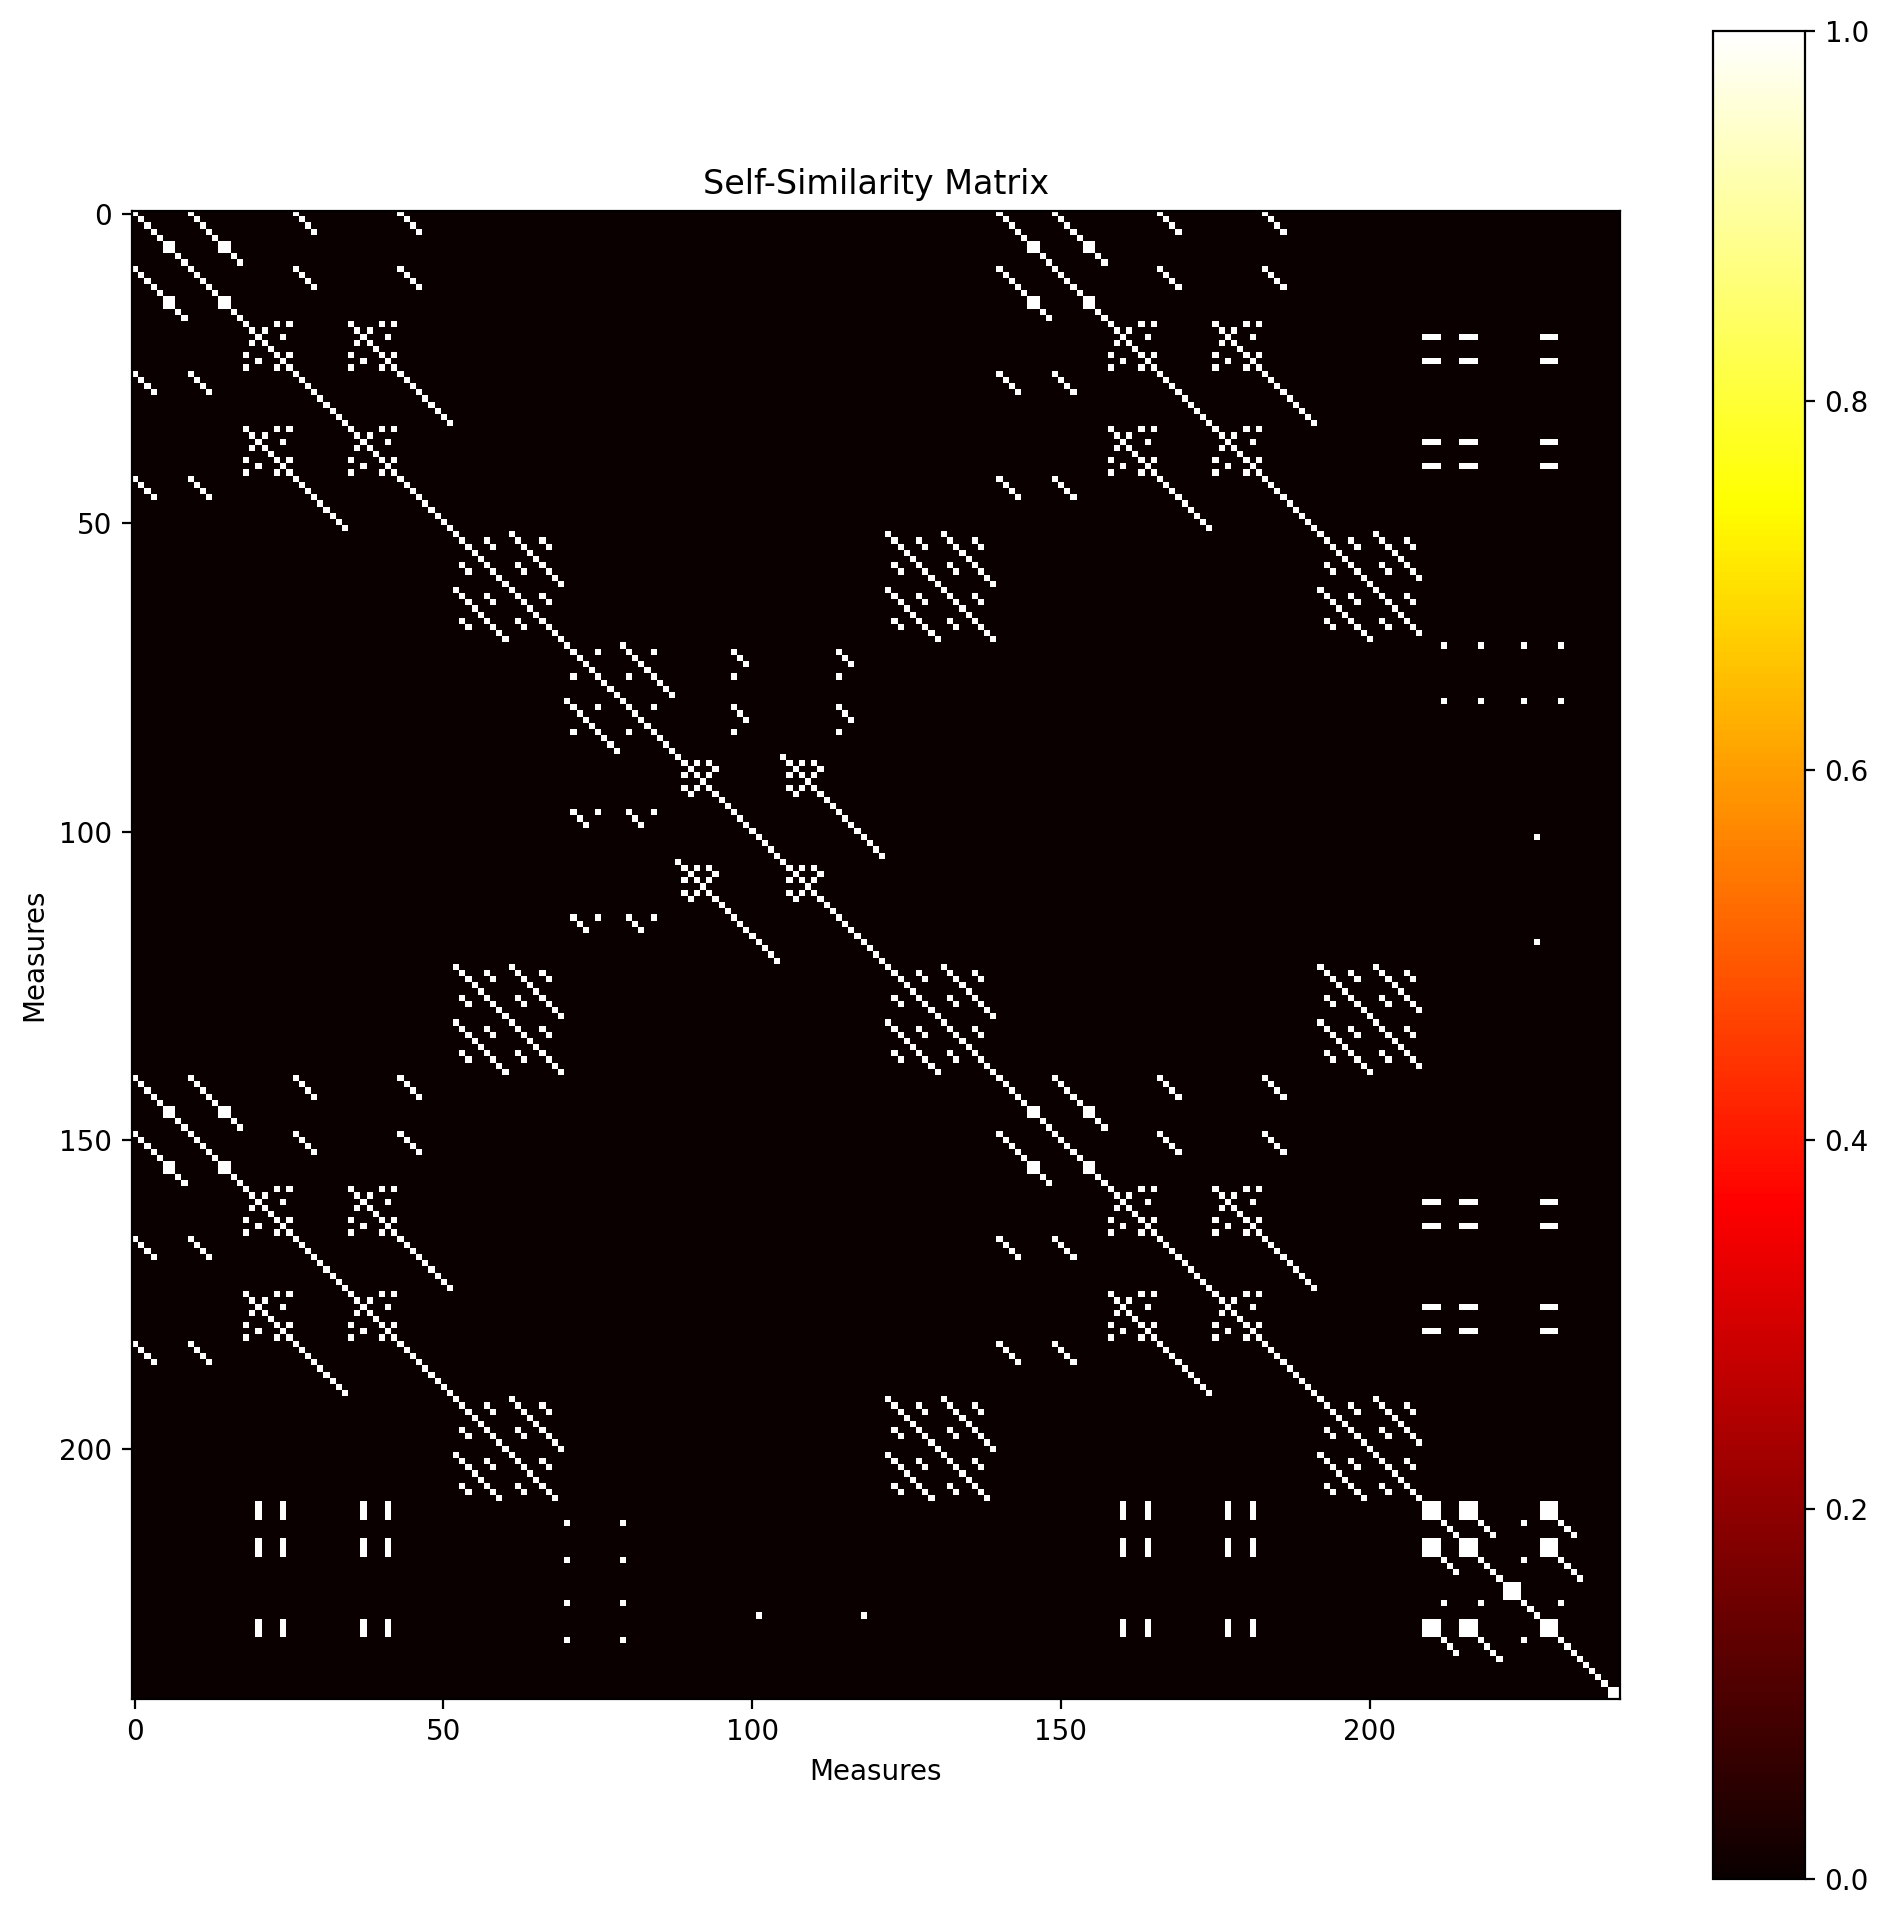

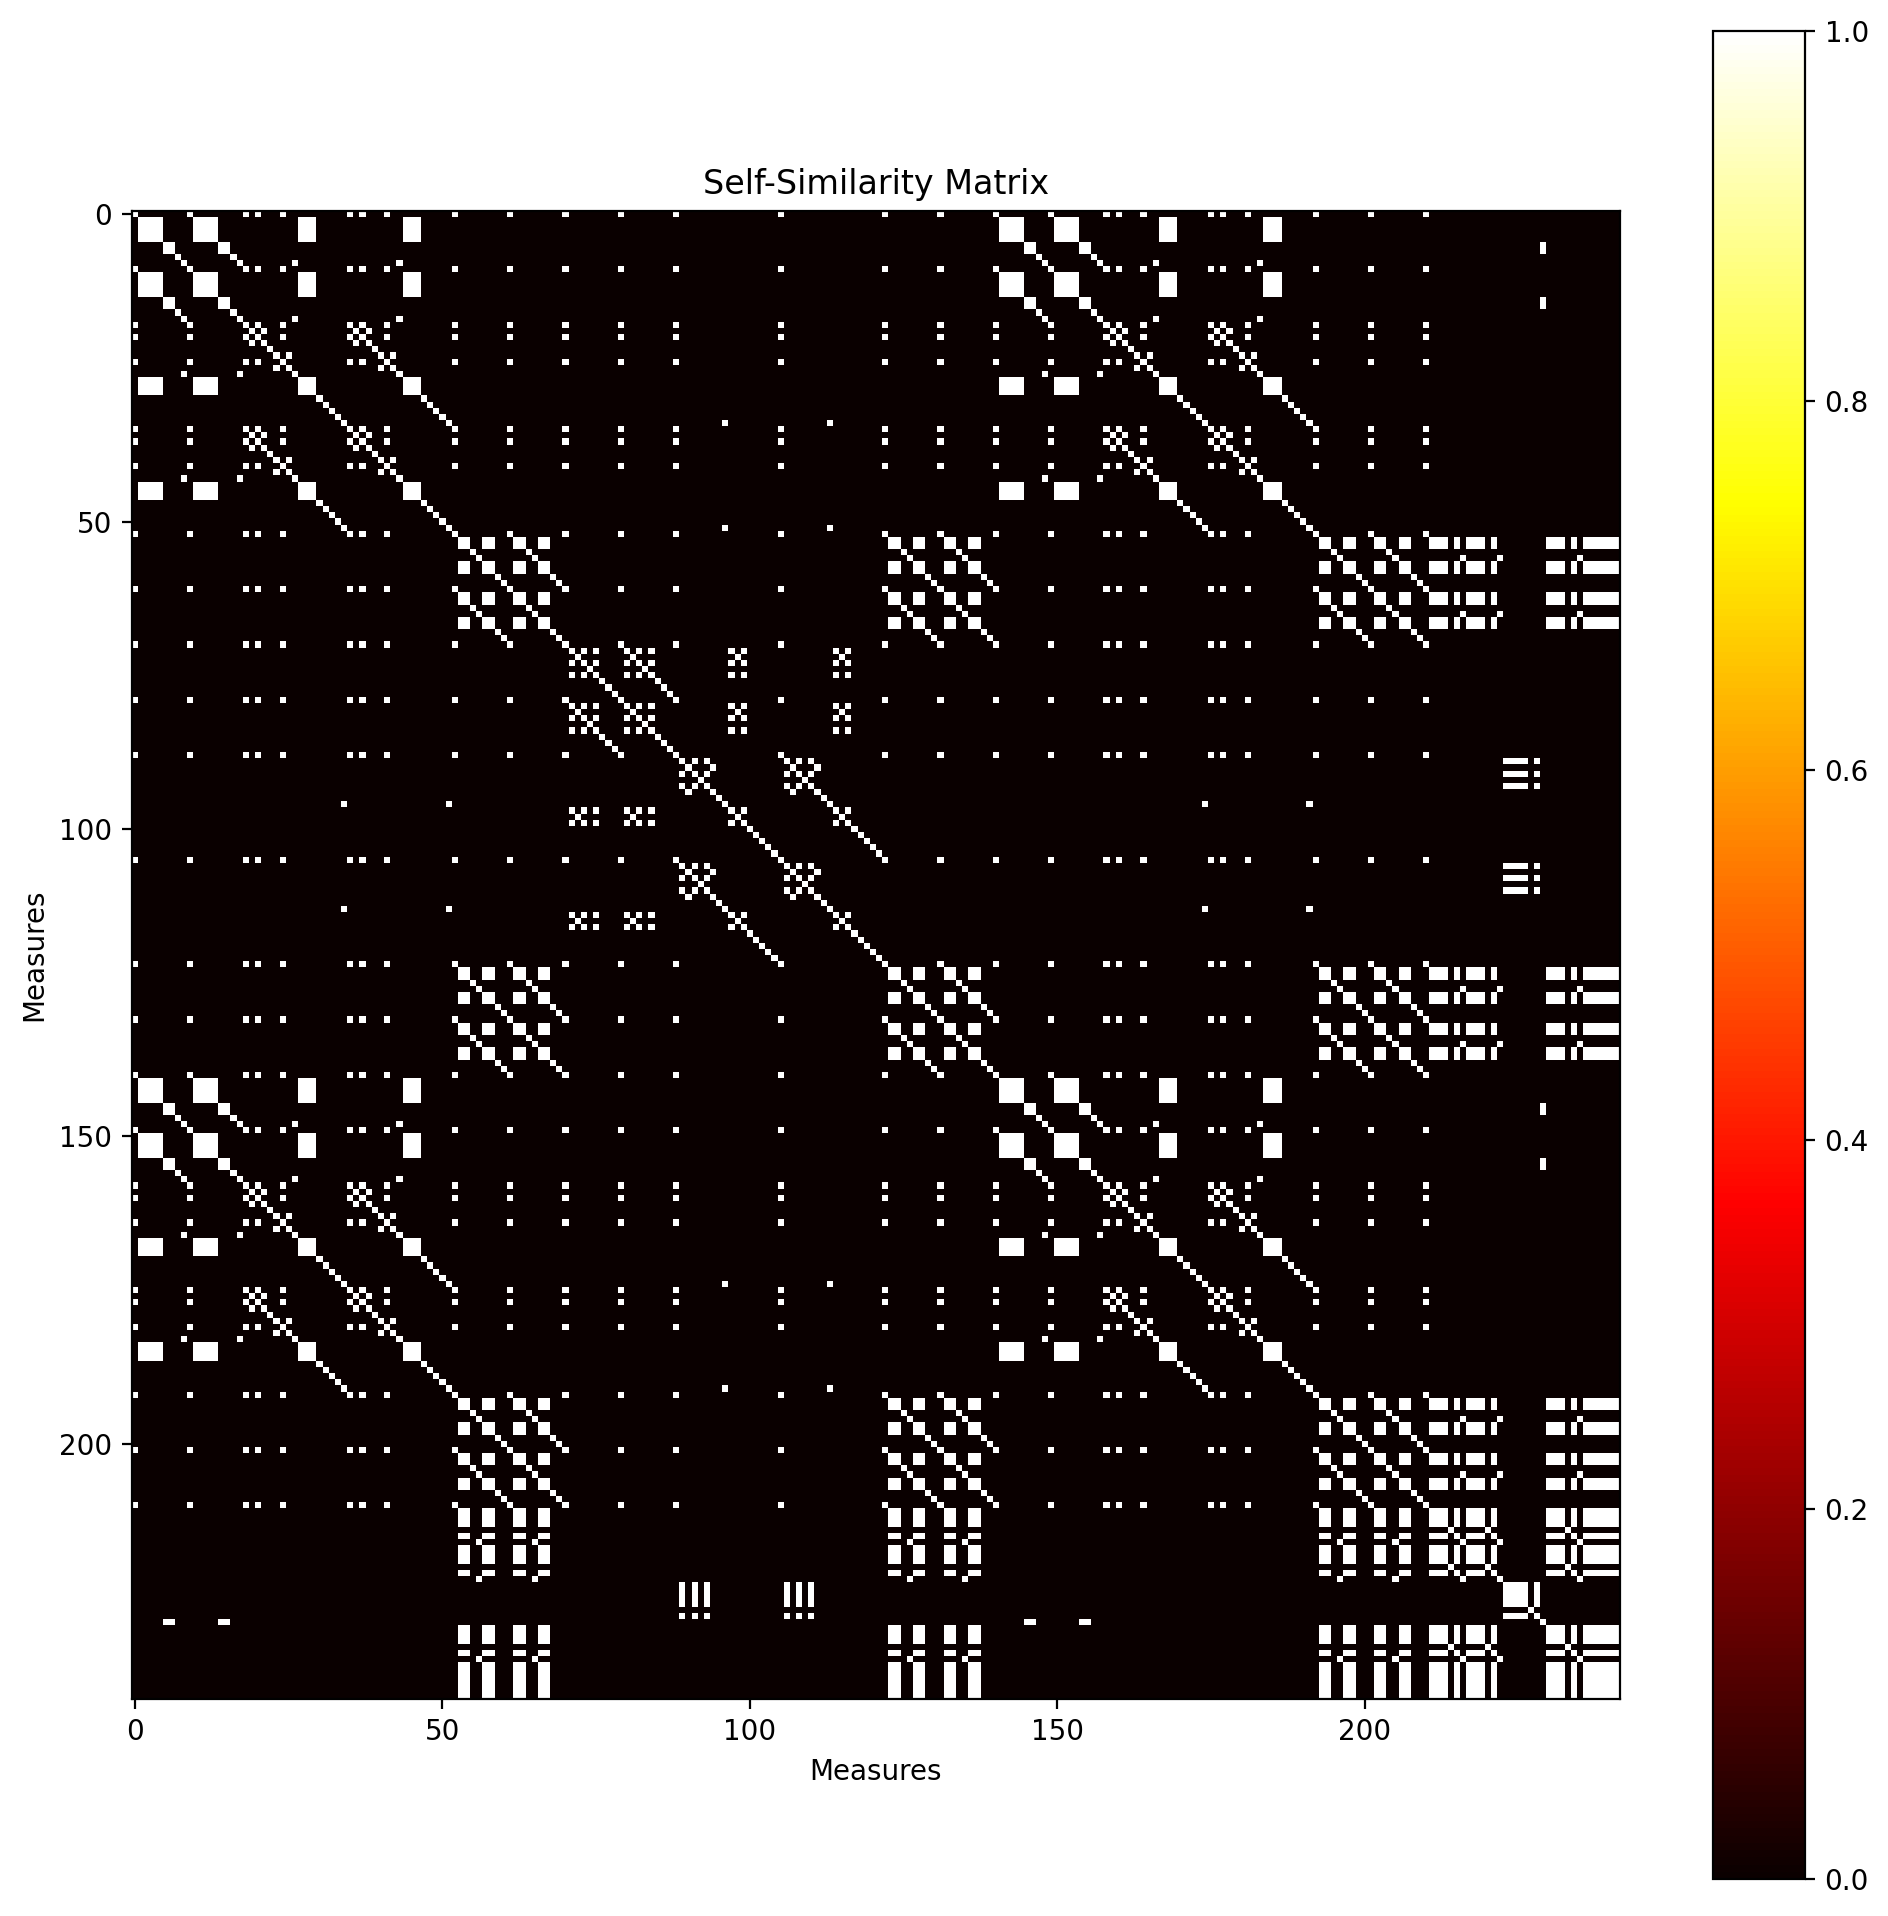

In [117]:
import numpy as np
import matplotlib.pyplot as plt

def longest_common_subsequence(seq1, seq2, comp):
    """
    Return the length of the longest common subsequence between two sequences.
    """
    # Initialize a 2D NumPy array to hold the lengths of common subsequences
    lcs = np.zeros((len(seq1) + 1, len(seq2) + 1))
    
    # Iterate over the sequences and fill in the lcs array
    for i in range(1, len(seq1) + 1):
        for j in range(1, len(seq2) + 1):
            # if seq1[i - 1] == seq2[j - 1]:
            #     lcs[i, j] = lcs[i - 1, j - 1] + 1
            # else:
            #     lcs[i, j] = max(lcs[i - 1, j], lcs[i, j - 1])
            lcs[i, j] = max(
                lcs[i - 1, j - 1] + comp(seq1[i - 1], seq2[j - 1]),
                lcs[i - 1, j],
                lcs[i, j - 1]
            )
    
    # Return the length of the longest common subsequence
    return lcs[-1, -1]

def lcs_similarity(seq1, seq2, comp):
    """
    Return the similarity of two sequences based on the length of their longest common subsequence.
    """
    # Compute the length of the longest common subsequence
    lcs_length = longest_common_subsequence(seq1, seq2, comp)
    
    # Normalize the length of the longest common subsequence
    min_length = min(len(seq1), len(seq2))
    similarity = lcs_length / min_length if min_length > 0 else 0
    
    return similarity

def id_comp(a, b):
    return 1 if a == b else 0

def chord_comp(chord1, chord2):
    return lcs_similarity(chord1, chord2, id_comp)

def measure_comp(measure1, measure2):
    return lcs_similarity(measure1, measure2, chord_comp)

def note_set_comp(measure1, measure2):
    #flatten the list of notes
    measure1 = set([note for chord in measure1 for note in chord])
    measure2 = set([note for chord in measure2 for note in chord])
    return 1 if measure1 == measure2 else 0

def note_set_iou(measure1, measure2):
    #flatten the list of notes
    measure1 = set([note for chord in measure1 for note in chord])
    measure2 = set([note for chord in measure2 for note in chord])
    inter = measure1.intersection(measure2)
    union = measure1.union(measure2)
    if len(union) == 0:
        return 0
    return len(inter) / len(union)

def compute_self_similarity(part):
    num_measures = len(part)
    # Initialize a 2D NumPy array to hold the self-similarity matrix
    self_similarity = np.zeros((num_measures, num_measures))

    # Iterate through each pair of measures
    for i in range(num_measures):
        for j in range(num_measures):

            # # simple equality check
            # similarity = 1 if part[i] == part[j] else 0

            # # lcs similarity
            # similarity = lcs_similarity(part[i], part[j], id_comp)

            # # measure similarity
            # similarity = measure_comp(part[i], part[j])

            # note set similarity
            similarity = note_set_comp(part[i], part[j])

            # # # note set iou
            # similarity = note_set_iou(part[i], part[j])

            self_similarity[i, j] = similarity

            # # Compute the similarity between the two measures
            # similarity = 0
            # for note1 in part[i]:
            #     for note2 in part[j]:
            #         if isinstance(note1, list) and isinstance(note2, list):
            #             # Compute the Jaccard similarity for two chords
            #             similarity = len(set(note1).intersection(note2)) / len(set(note1).union(note2))
            #         elif isinstance(note1, list) or isinstance(note2, list):
            #             # Compute the Jaccard similarity for a chord and a note
            #             similarity = len(set(note1).intersection(note2)) / len(set(note1).union(note2))
            #         else:
            #             # Compute the Jaccard similarity for two notes
            #             similarity = int(note1 == note2)
            #         # Update the similarity value in the self-similarity matrix
            #         self_similarity[i, j] += similarity

    return self_similarity

# Example usage
for part in parts_notes:
    self_similarity = compute_self_similarity(part)
    # Plot the self-similarity matrix
    plt.imshow(self_similarity, cmap='hot', interpolation='nearest')
    plt.title('Self-Similarity Matrix')
    plt.xlabel('Measures')
    plt.ylabel('Measures')
    plt.colorbar()
    plt.gcf().set_size_inches(12, 12)
    plt.show()